# 04b - Vertex AI - AutoML for Global Forecasting with Deep Learning - In GCP Console (no code)

A newer way to fit forecast models to time series data is by using a deep learning approach with neural networks. This approah can have added success because it is a global forecast, it not only sees and individual time series but also sees across many time series and can learn together from correlation.  This approach can also include covariate features that may only be known in the past or may also be available at forecast time. Vertex AI AutoML forecasting will do automatic feature engineering, model architecture search and hyperparameter tuning specific to time series data.  This method using a set of data between the training data and the test data called validation data to time series specific approachs using deep learning architectures.  

**In this notebook, screenshots are shared that illustrate a no-code walk-through all using the Vertex AI interface in the GCP Console.**  The best part, is all the test data will be forecasted and written back to BigQuery where we will review it, visualize it, and calcualte custom metrics to make fair comparison to other methods explored in this notebook series (`04`).

### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Create Dataset
- Train Forecasting Model with AutoML
    - Training Method
    - Model Details
    - Training Options
    - Compute and Pricing
    - Review Training
- Forecasting Model
- Test Data in BigQuery
- Setup
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve the Forecasting Data (raw series)
    - Visualize the Time Series with Forecast

### Resources:
- [Train an AutoML model (Cloud Console)](https://cloud.google.com/vertex-ai/docs/training/automl-console#forecasting)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Optimization objectives for tabular AutoML models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)
- [Evaluation metrics returned by Vertex AI](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#evaluation_metrics_returned_by)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04b_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04b_console.png">

---
## Create Dataset (Link to BigQuery Table)

From the Console:
- Go to Vertex AI
- Select `Datasets`
- Select `+ CREATE`

<img src="architectures/notebooks/04b_screenshots/ds_1.png">

- Name the Dataset `04b`
- Select `Tabular`
    - Select `Forecasting`
- Select `us-central (Iowa)`
- Select `CREATE`

<img src="architectures/notebooks/04b_screenshots/ds_2.png">

- Select `Select a table or view from BigQuery`
- Enter the BigQuery path (or browse) to the table created in notebook `04`
- Select `CONTINUE`

<img src="architectures/notebooks/04b_screenshots/ds_3.png">

- The `ANALYZE` tab will be displayed for review
- Select the `Series identifier column` as `start_station_name`
- Select the `Timestamp column` as `date`
- Select `TRAIN NEW MODEL`

<img src="architectures/notebooks/04b_screenshots/ds_4.png">

---
## Train Forecasting Model with AutoML

After creating the `Dataset` above, we selected `TRAIN NEW MODEL` which presents the first screen of the process

### Training Method

- Select `AutoML`
- Select `CONTINUE`

<img src="architectures/notebooks/04b_screenshots/train_1.png">

### Model Details

- For `Target column` select `num_trips`
- For `Series identifier column` select `start_station_name`
- For Timestamp column` select `date`
- For `Data granularity` select `Daily`
- For `Forecast horizon` enter `14`
- For `Context window` enter `14`
- Select `Export test dataset to BigQuery`
- For `BigQuery path` enter a new table for the same dataset
- Select `Cancel training` under `Data validation options
- Select `Manual` for `Data split`
    - Enter `splits` for `Data split column`
- Select `CONTINUE`

<img src="architectures/notebooks/04b_screenshots/train_2.png">

### Training Options

- Review the `Training options` overview of column names and assignments
- Under `ADVANCED OPTIONS` you can select the `Optimization objective`
    - The default is RMSE and used for this notebook
    - See more about [optimization objectives for forecasting models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)

<img src="architectures/notebooks/04b_screenshots/train_3.png">

### Compute and pricing

- For budget enter `1 hour`
- Select `START TRAINING`

<img src="architectures/notebooks/04b_screenshots/train_4.png">

### Review Training

- Under the Vertex AI section for `Training`, on the `TRAINING PIPELINES` tab you will see the job in progress with a `Status` of `Training`

<img src="architectures/notebooks/04b_screenshots/train_5.png">


---
## Forecasting Model

- When the Training is complete, `Status` of `Finished`, you can select the name of the `TRAINING PIPELINES` task to go to the model

<img src="architectures/notebooks/04b_screenshots/train_6.png">

- The first tab presented for the model is `EVALUATE` where you can see overall model metrics
    - Review the [metrics definitions here](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#forecasting)
- Select the `MODEL PROPOERTIES` tab

<img src="architectures/notebooks/04b_screenshots/model_1.png">

- Review the model proprties
- Select `VIEW DETAILS` under `Column metadata`

<img src="architectures/notebooks/04b_screenshots/model_2.png">

- Select `DONE`
- Select the `BATCH PREDICTIONS` tab

<img src="architectures/notebooks/04b_screenshots/model_3.png">

- Review the options to create a batch predictions job
- Click `CANCEL` as we output the test predictions to BigQuery as part of the AutoML Training

<img src="architectures/notebooks/04b_screenshots/model_4.png">

---
## Test Data in BigQuery

- In the console go to `BigQuery` and expand the project, dataset, and select the table for the test data, select the `PREVIEW` tab:

<img src="architectures/notebooks/04b_screenshots/bq_1.png">


---
## Setup

inputs:

In [10]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04b'

packages:

In [11]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [12]:
bigquery = bigquery.Client()

---
## Results

### Retrieve Test Data

In [14]:
query = f"""
WITH
    RAW AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM RAW
    ),
    LEFTSIDE AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD
        GROUP BY start_station_name, date
    )
SELECT *
FROM LEFTSIDE
LEFT OUTER JOIN LEAD
USING (start_station_name, date, prediction_lead_days)
"""
autoML = bigquery.query(query = query).to_dataframe()
autoML

,start_station_name,date,prediction_lead_days,predicted_on_date,num_trips,splits,predicted_num_trips
0,Central Park S & 6 Ave,2016-09-17,0,2016-09-17,607,TEST,466.326172
1,Central Park W & W 96 St,2016-09-17,0,2016-09-17,153,TEST,153.772690
2,Central Park West & W 68 St,2016-09-17,0,2016-09-17,251,TEST,234.526474
3,Central Park West & W 72 St,2016-09-17,0,2016-09-17,264,TEST,320.872406
4,Central Park West & W 76 St,2016-09-17,0,2016-09-17,177,TEST,173.268585
...,...,...,...,...,...,...,...
154,Central Park West & W 100 St,2016-09-30,0,2016-09-30,13,TEST,42.819920
155,Central Park West & W 102 St,2016-09-30,0,2016-09-30,10,TEST,53.169155
156,W 106 St & Central Park West,2016-09-30,0,2016-09-30,32,TEST,69.693214
157,Grand Army Plaza & Central Park S,2016-09-30,0,2016-09-30,43,TEST,241.260330


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [15]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.746698,46.081583,0.296890
1,Central Park S & 6 Ave,forecast,0.533698,76.547331,0.234551
2,Central Park W & W 96 St,forecast,0.646452,23.388470,0.233718
3,Central Park West & W 100 St,forecast,1.059021,16.680039,0.420758
4,Central Park West & W 102 St,forecast,0.567061,13.854297,0.273569
5,Central Park West & W 68 St,forecast,0.509117,47.525286,0.313698
6,Central Park West & W 72 St,forecast,0.678491,57.839550,0.326919
7,Central Park West & W 76 St,forecast,0.404354,27.569563,0.251777
8,Central Park West & W 85 St,forecast,1.188514,54.133789,0.430610
9,Grand Army Plaza & Central Park S,forecast,0.558010,54.691731,0.251501


Overall Metrics:

In [16]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type    
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE
0,forecast,0.61161,37.576466,0.280566


### Retrieve the Forecasting Data (raw series)

In [17]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [18]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize The Time Series with Forecast

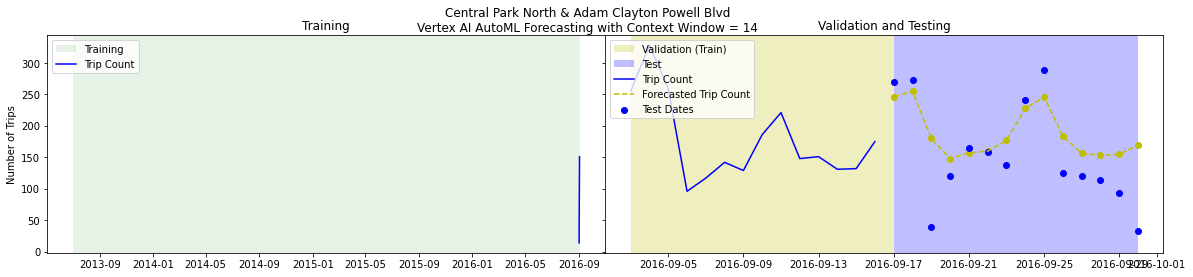

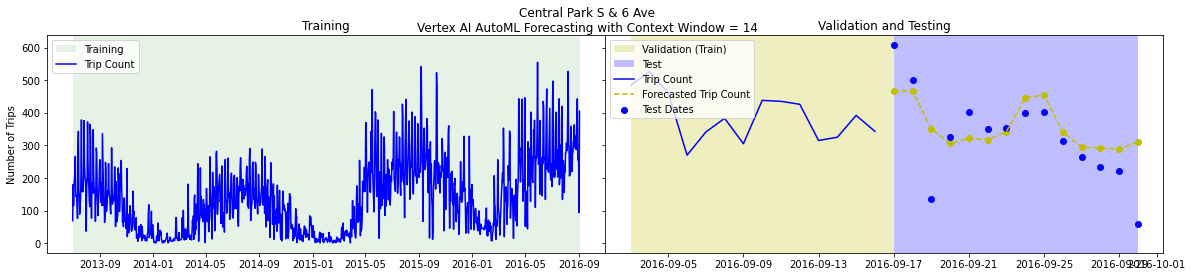

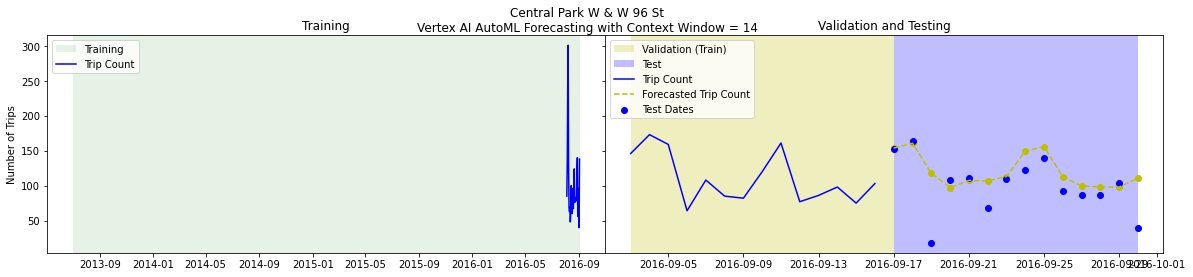

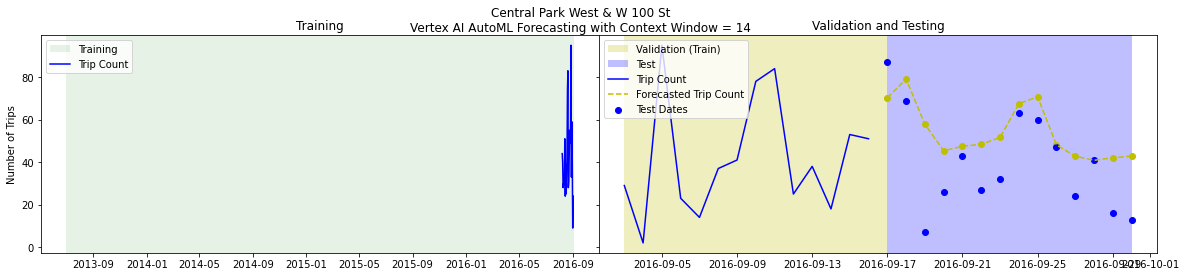

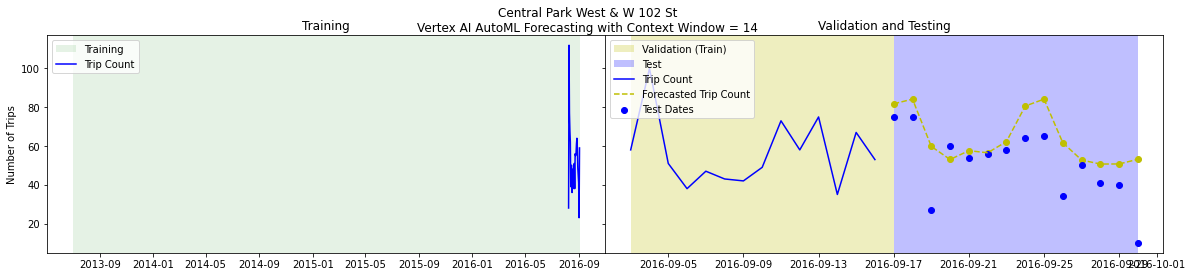

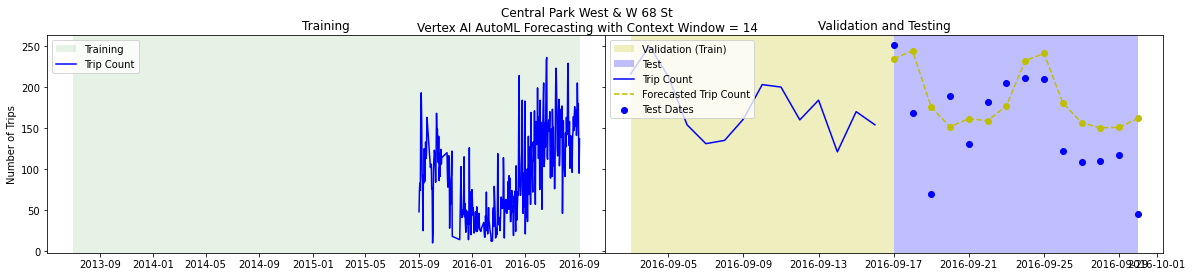

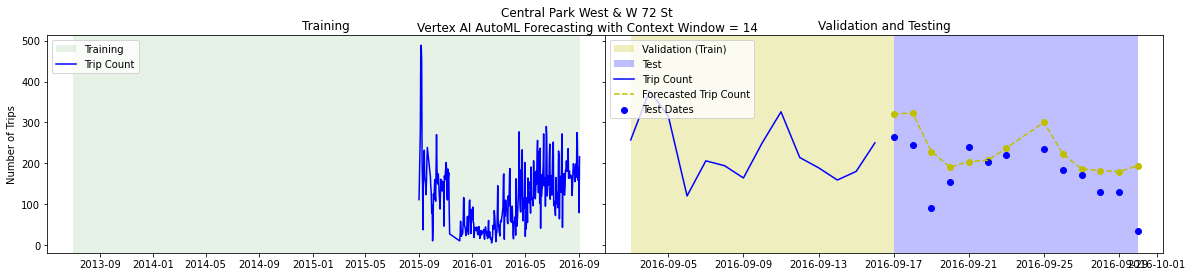

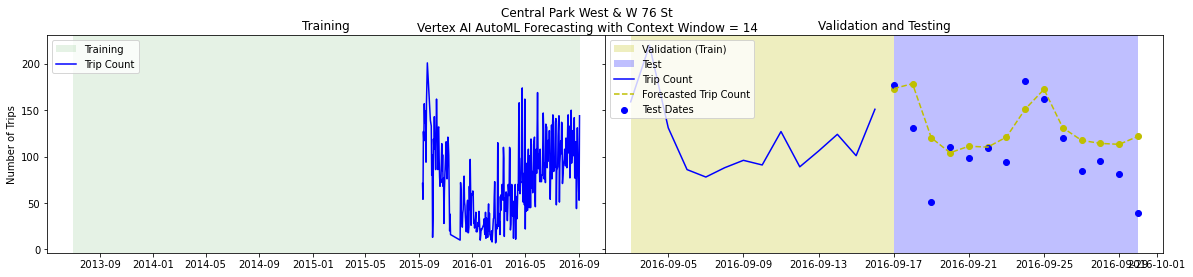

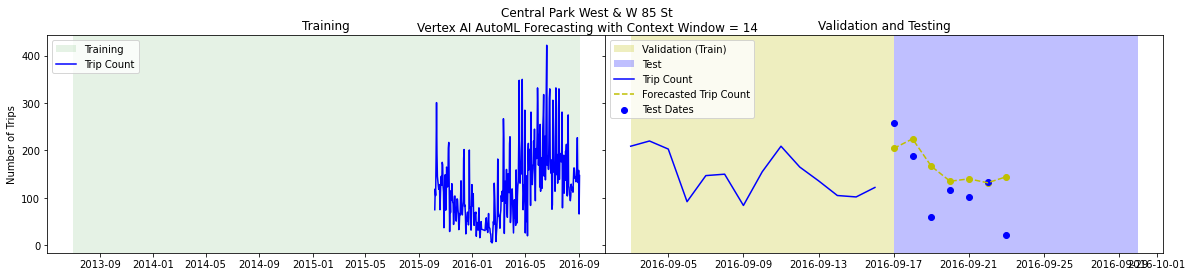

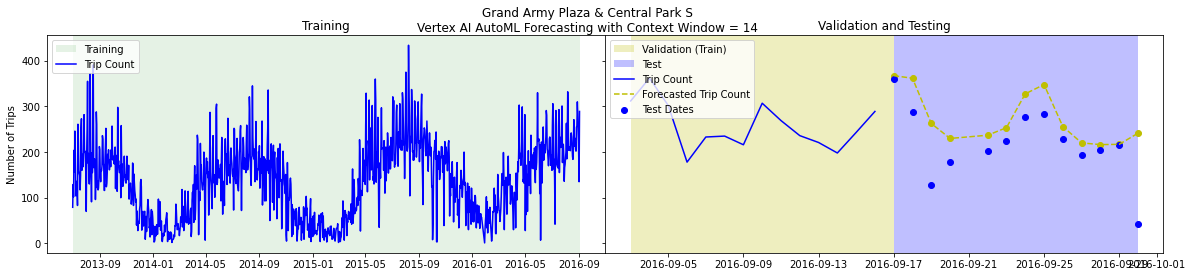

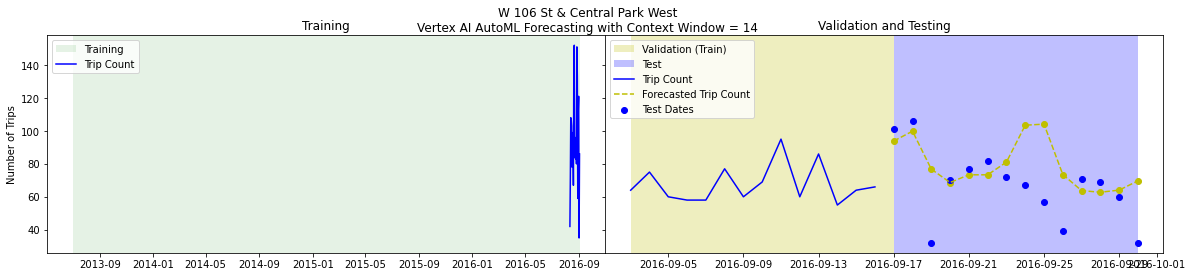

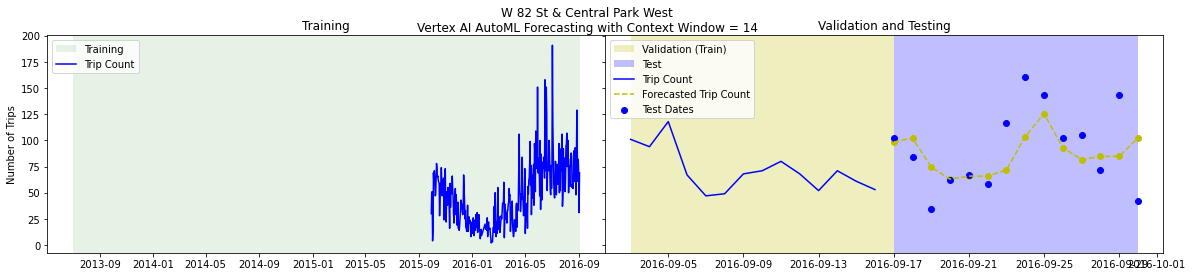

In [21]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[1].plot(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nVertex AI AutoML Forecasting with Context Window = 14")

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"